# Spherical Gaussians

> 相关引擎代码：`Engine\Shaders\Private\SphericalGaussian.ush`

## Motivation

回顾渲染方程：
$$
L_r(\omega_o) = \int\limits_\Omega f(\omega_i, \omega_o) L_i(\omega_i) \max(0, n \cdot \omega_i) d \omega_i
$$

其中:
- BRDF：$f(\omega_i, \omega_o)$
- 入射光：$L_i(\omega_i)$
- Clamped Cosine：$\max(0, n \cdot \omega_i)$  

都可以看做是定义在球面上的函数。由于它们是很复杂的函数，在离线渲染中，可以使用蒙特卡洛方法来求数值解。还有一个思路是：使用形式更简单的函数来近似这几个函数，然后求出解析解。

球面高斯函数就是可以用来做这种近似的一个函数，主要有两方面的原因：

1. 它的积分比较好求，因为：$\int e^x d x = e^x$
2. 两个球面高斯函数的内积，有一个解决解，详见：The Inner Product 一节

使用球面高斯函数近似求解渲染方程的详细推导，请见：[All-Frequency Rendering of Dynamic, Spatially-Varying Reflectance](https://www.microsoft.com/en-us/research/video/frequency-rendering-dynamic-spatially-varying-re%ef%ac%82ectance/)

## Definition

$$
G(\mathbf{v} ; \mathbf{p}, \lambda, \mu)=\mu e^{\lambda(\mathbf{v} \cdot \mathbf{p}-1)}
$$

- $\mathbf{v}$: the spherical parameter of the resulting function, $\mathbf{v} \in \mathbb{S}^{2}$
- $\mathbf{p}$: the lobe axis, $\mathbf{p} \in \mathbb{S}^{2}$
- $\lambda$: the lobe sharpness, $\lambda \in(0,+\infty)$
- $\mu$: the lobe amplitude, $\mu \in \mathbb{R}$ ($\mu \in \mathbb{R}^3$ for RGB color)

## The Vector Product

$$
\begin{aligned}
\left(G_{1} \otimes G_{2}\right)(\mathbf{v}) &=G_{1}(\mathbf{v}) G_{2}(\mathbf{v}) \\
&=G\left(\mathbf{v} ; \frac{\mathbf{p}_{m}}{\left\|\mathbf{p}_{m}\right\|}, \lambda_{m}\left\|\mathbf{p}_{m}\right\|, \mu_{1} \mu_{2} e^{\lambda_{m}\left(\left\|\mathbf{p}_{m}\right\|-1\right)}\right)
\end{aligned}
$$

- $\mathbf{p}_{m}=\left(\lambda_{1} \mathbf{p}_{1}+\lambda_{2} \mathbf{p}_{2}\right) /\left(\lambda_{1}+\lambda_{2}\right)$
- $\lambda_{m}=\lambda_{1}+\lambda_{2}$


## The Inner Product

$$
G_{1} \cdot G_{2}=\int_{\mathbb{S}^{2}} G_{1}(\mathbf{v}) G_{2}(\mathbf{v}) \mathrm{d} \mathbf{v}=\frac{4 \pi \mu_{1} \mu_{2}}{e^{\lambda_{1}+\lambda_{2}}} \frac{\sinh \left(d_{m}\right)}{d_{m}}
$$

- $d_{m}=\left\|\lambda_{1} \mathbf{p}_{1}+\lambda_{2} \mathbf{p}_{2}\right\|$

## Visualization

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
sys.path.append('../project_viz')
from umath import spherical_plot

In [3]:
def spherical_gaussian(direction, axis, sharpness, amplitude):
    return amplitude * np.exp(sharpness * (np.dot(axis, direction) - 1))

interactive(children=(FloatSlider(value=3.0, description='sharpness', max=10.0, step=3.0), FloatSlider(value=5…

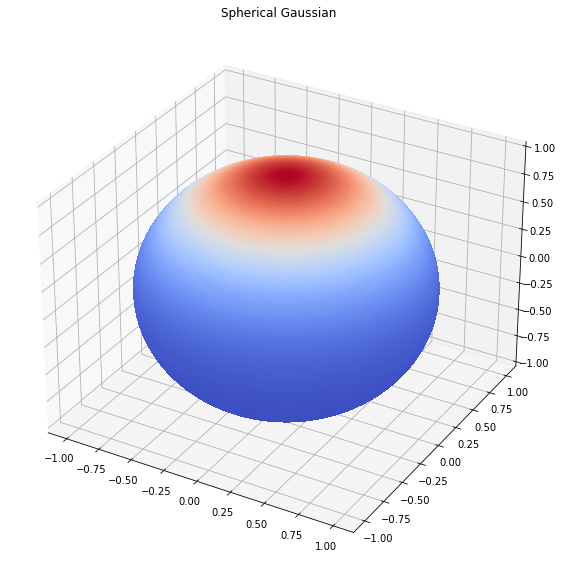

In [4]:
@widgets.interact(sharpness=(0.0, 10.0, 3.0),amplitude=(0.0, 10.0, 5.0))
def my_plot(sharpness,amplitude):
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    spherical_plot.heatmap(spherical_gaussian, ax, axis=[0,0,1], sharpness = sharpness, amplitude=amplitude)

    plt.title('Spherical Gaussian')
    plt.show()

my_plot(3,5)

## Fitting the Clamped Cosine

In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

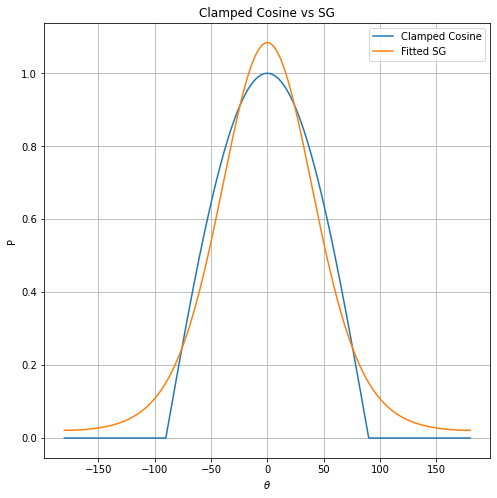

lambda_fit = 1.96859694526707, mu_fit = 1.0838906771919112
MES =  0.004695321843466131


In [6]:
def SG(cos_theta, sharpness, amplitude):
    p = sharpness*(cos_theta-1)
    return amplitude*np.exp(p)

def clamped_cosine(cos_theta):
    return np.maximum(cos_theta, 0)

x_rad = np.linspace(-np.pi, np.pi, 2000)
x_cos = np.cos(x_rad)
x_deg = np.rad2deg(x_rad)

cc = clamped_cosine(x_cos)

popt, pcov = curve_fit(SG, x_cos, cc)
lambda_fit = popt[0]
mu_fit = popt[1]

approx = SG(x_cos, lambda_fit, mu_fit)

fig = plt.figure(figsize=[8,8])
plt.title("Clamped Cosine vs SG")
plt.xlabel("$\\theta$")
plt.ylabel("P")

plt.plot(x_deg, cc, label="Clamped Cosine")
plt.plot(x_deg, approx, label="Fitted SG")

plt.grid()
plt.legend()
plt.show()


# mean squared error
def MSE(Y, YH):
    return np.square(Y - YH).mean()

print('lambda_fit = {0}, mu_fit = {1}'.format(lambda_fit, mu_fit))
print('MES = ', MSE(approx, cc))

## References

- Jiaping Wang, et al., ["All-Frequency Rendering of Dynamic, Spatially-Varying Reflectance"](https://www.microsoft.com/en-us/research/video/frequency-rendering-dynamic-spatially-varying-re%ef%ac%82ectance/), ACM Transactions on Graphics, January 2007
- Matt Pettineo, ["Lightmap Baking and Spherical Gaussians"](https://therealmjp.github.io/posts/new-blog-series-lightmap-baking-and-spherical-gaussians/)
- Matt Pettineo, ["Approximating Subsurface Scattering With Spherical Gaussians"](https://therealmjp.github.io/posts/sss-sg/)